In [1]:
import os
import torch
import warnings
import pandas as pd
import numpy as np

from torch import nn
from termcolor import colored
from tqdm.notebook import tqdm
from collections import defaultdict
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, get_scheduler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
d_train = pd.read_csv("train.csv")
d_test = pd.read_csv("test.csv")
d_train.id = np.arange(len(d_train))
labels_count = len(d_train.lib.unique())
d_train

,title,lib,id
0,Is there a way to sort strings in alphabetical...,functools,0
1,Maintaining history by soft deleting the row o...,django,1
2,Wave on a string analysis,numpy,2
3,Regular expression find word but NOT if it's p...,re,3
4,TextBlob - Loop over articles to calculate pol...,pandas,4
...,...,...,...
134019,Add background image to html.div in Dash-plotly,datetime,134019
134020,Gathering information from few forms in django,django,134020
134021,How to manually populate Many-To-Many fields t...,django,134021
134022,Turtle Graphics - Alternate Colors of Letters ...,itertools,134022


In [4]:
max_len = 80

In [5]:
id_train = []
id_test = []
p = 0.8
for i in range(labels_count):
    ids = d_train[d_train.lib == d_train.lib.unique()[i]].id.to_numpy()
    mask = np.random.choice([0, 1], size=len(ids), p=[p, 1 - p])
    id_test.extend(ids[mask == 1])
    id_train.extend(ids[mask == 0])

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [7]:
class titlesDataset(Dataset):
    def __init__(self, dt, tokenizer, unique_libs, max_len=30):
        self.max_len = max_len
        self.titles = dt.title.to_numpy()
        self.libs = dt.lib.to_numpy()
        self.tokenizer = tokenizer
        self.unique_libs = unique_libs
    
    def __getitem__(self, index):
        tokens = tokenizer(self.titles[index], max_length=self.max_len, padding="max_length")
        lib = np.where(self.unique_libs == self.libs[index])[0][0]
        return torch.Tensor(tokens["input_ids"]).long(), torch.Tensor(tokens["attention_mask"]).short(), lib
    
    def __len__(self):
        return len(self.titles)

In [8]:
ds_train = titlesDataset(d_train.iloc[id_train], tokenizer, d_train.lib.unique(), max_len)
ds_val = titlesDataset(d_train.iloc[id_test], tokenizer, d_train.lib.unique(), max_len)

In [9]:
def collate_fn(batch):
    title_batch = torch.stack([elem[0] for elem in batch])
    mask_batch = torch.stack([elem[1] for elem in batch]).short()
    lib_batch = torch.Tensor([elem[2] for elem in batch]).long()
    return title_batch, mask_batch, lib_batch

In [10]:
batch_size = 64

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class gptKILLER(nn.Module):
    def __init__(self, tokenizer, token_count, labels, labels_count=24):
        super(gptKILLER, self).__init__()
        self.labels_count = labels_count
        self.token_count = token_count
        self.gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
        self.gpt2.resize_token_embeddings(len(tokenizer))
        self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id
        for param in self.gpt2.parameters():
            param.requires_grad = False
        self.gpt2.lm_head = Identity()
        self.embedding = self.gpt2.transformer.wte
        embedding_size = 768
        small_embedding = 256
        
        self.titles_decrease = nn.Linear(embedding_size, small_embedding)
        self.libs_decrease = nn.Linear(embedding_size, small_embedding)
        self.W = nn.Parameter(torch.randn(labels_count, small_embedding, small_embedding))
        self.fc = nn.Parameter(torch.randn(labels_count, token_count, 1))
        self.lib_transform =  nn.Parameter(torch.randn(labels_count, 1, 3))
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
        
        with torch.no_grad():
            nn.init.xavier_normal_(self.W, gain=1.0)
            nn.init.xavier_normal_(self.fc, gain=1.0)
            nn.init.xavier_normal_(self.lib_transform, gain=1.0)
        
        with torch.no_grad():
            self.labels_emb = self.gpt2.transformer.wte(labels.to(device)).to(device)
        
    def forward(self, titles, attention_mask):
        batch_size = titles.shape[0]
        
        labels_emb = self.libs_decrease(self.labels_emb)
        labels_emb = self.relu(labels_emb)
        labels_emb = (self.lib_transform @ labels_emb).transpose(1, 2)
        
        titles = self.titles_decrease(self.gpt2(titles, attention_mask=attention_mask).logits)
        titles = self.relu(titles)
        titles_emb = titles.unsqueeze(1).repeat(1, self.labels_count, 1, 1)
        k = self.W @ labels_emb
        output = (titles_emb @ k).transpose(2, 3)
        output = self.relu(output)
        output = (output @ self.fc).view(batch_size, self.labels_count)
        output = self.logsoftmax(output)
        return output

In [12]:
labels = tokenizer(d_train.lib.unique().tolist(), padding=True, return_tensors='pt').input_ids

In [13]:
def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        param[0],
                        beautiful_int(num_params),
                        param[1].requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        if param[1].requires_grad:
            sum_learnable_params += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    return sum_params, sum_learnable_params

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimized_params = []
    for param in model.parameters():
        if param.requires_grad:
            optimized_params.append(param)
    optimizer = torch.optim.Adam(optimized_params, lr, [beta1, beta2])
    return model, optimizer

In [15]:
def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for titles_batch, mask_batch, libs_batch in tqdm(loader):
        optimizer.zero_grad()
        titles_batch = titles_batch.cuda()
        mask_batch = mask_batch.cuda()
        libs_batch = libs_batch.cuda()
        pred = model(titles_batch, attention_mask=mask_batch)
        loss = criterion(pred, libs_batch)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for titles_batch, mask_batch, libs_batch in tqdm(loader):
            titles_batch = titles_batch.cuda()
            mask_batch = mask_batch.cuda()
            libs_batch = libs_batch.cuda()
            pred = model(titles_batch, attention_mask=mask_batch)
            loss = criterion(pred, libs_batch)

            losses_val.append(loss.item())
            
            if metric_names is not None:
                if 'accuracy' in metric_names:
                    preds = torch.argsort(pred, dim=1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f'accuracy ~ top#{k}'].append(
                            np.mean([libs_batch[i].item() in preds[i, :k] for i in range(libs_batch.shape[0])])
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    
    if os.path.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    os.makedirs(os.path.join(chkp_folder, model_name))
    
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            if ((not save_only_best) or (loss < best_val_loss)):
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name, f'{model_name}#{epoch}.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f'additional metrics #{plot_id}')
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                        plt.legend()
                        plt.grid()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

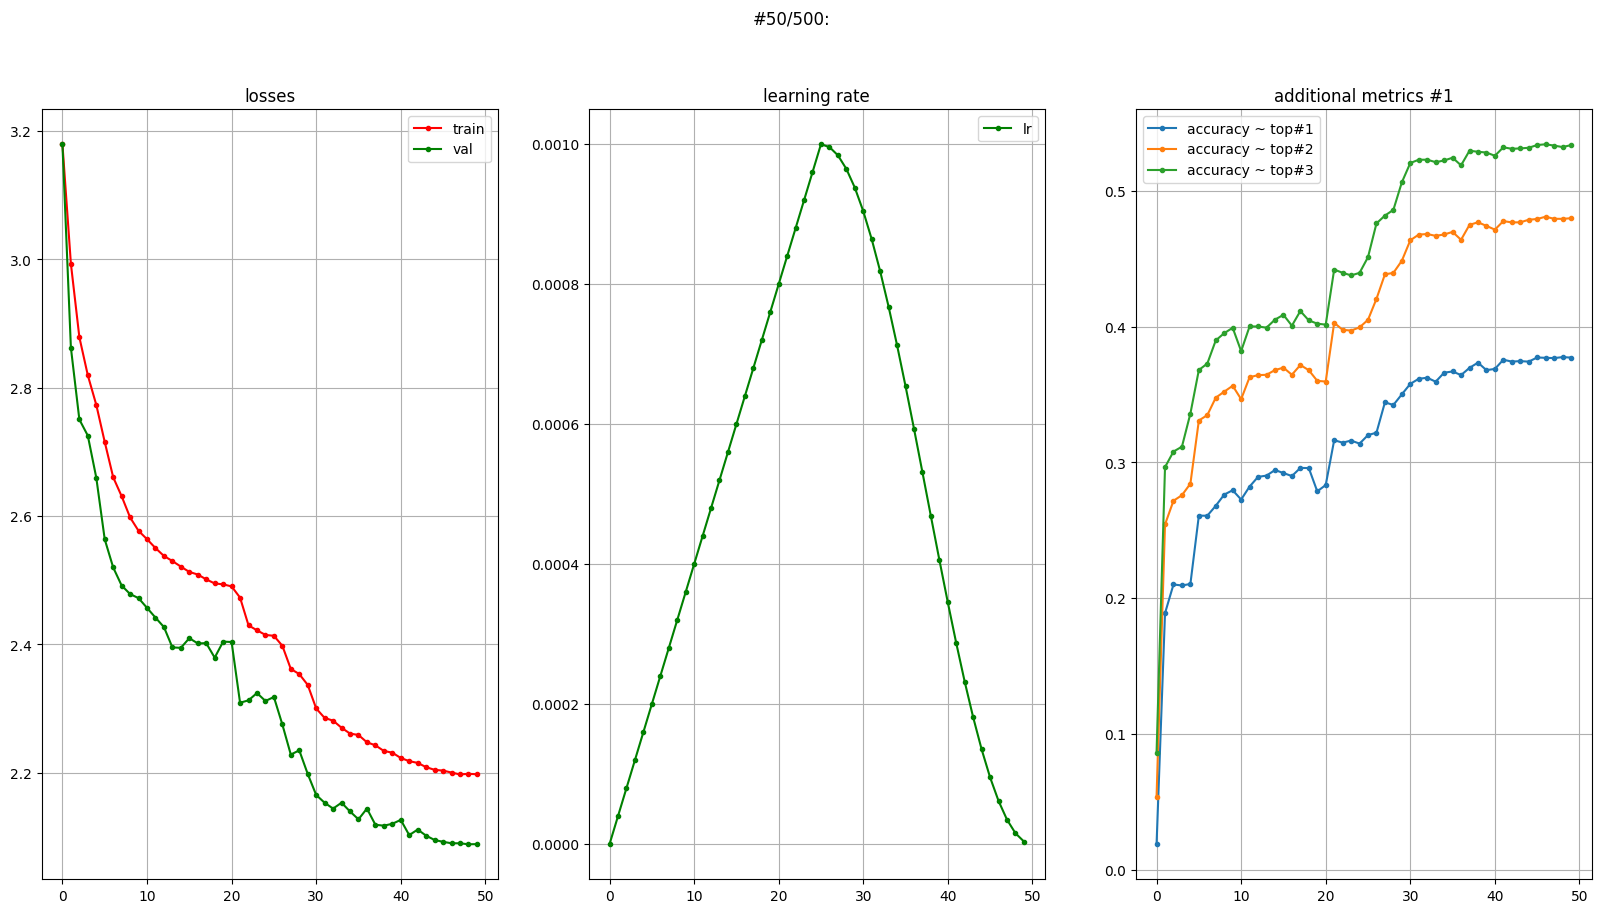

Learning process ended with early stop after epoch 50
CPU times: user 2h 18min 42s, sys: 23.3 s, total: 2h 19min 5s
Wall time: 2h 18min 47s


In [17]:
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(
    model_class = gptKILLER,
    model_params = {
        "tokenizer": tokenizer, 
        "token_count": max_len,
        "labels": labels
    },
    lr = 1e-3,
    device = device,
)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.98, patience=4, threshold=0.001, verbose=True)
scheduler = get_scheduler("cosine_with_restarts", optimizer, 25, 50)
criterion = nn.NLLLoss()

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 500,
    min_lr = 1e-8,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 2, 3], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "gpt2smallWarmUp"
)

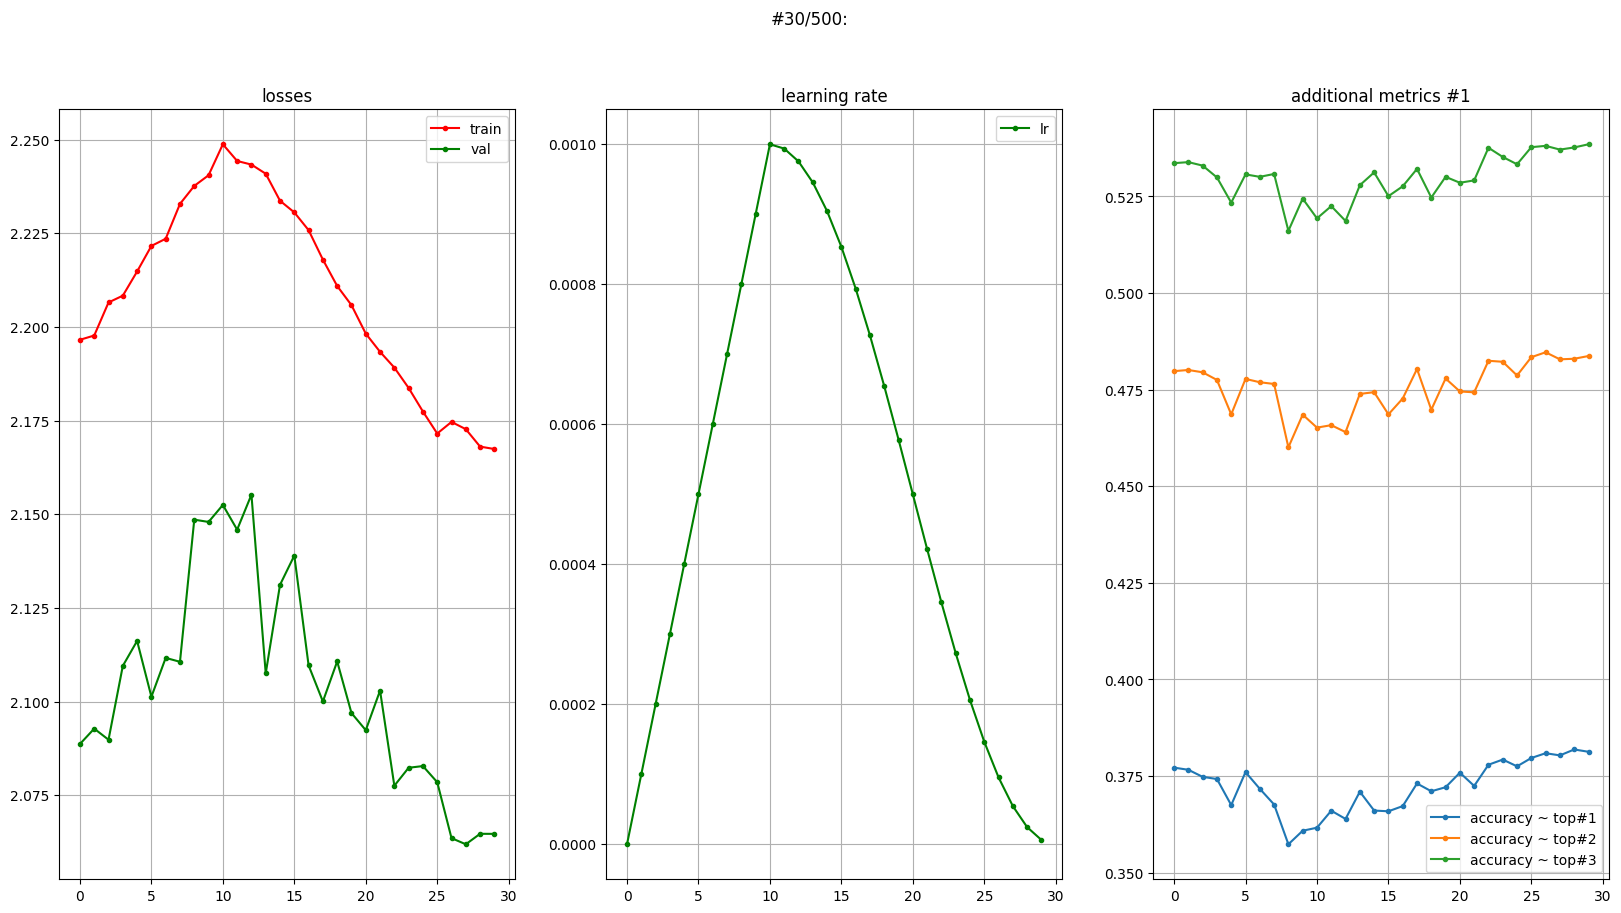

Learning process ended with early stop after epoch 30


In [18]:
scheduler = get_scheduler("cosine_with_restarts", optimizer, 10, 30)
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 500,
    min_lr = 1e-9,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 2, 3], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "gpt2smallWarmUpC"
)

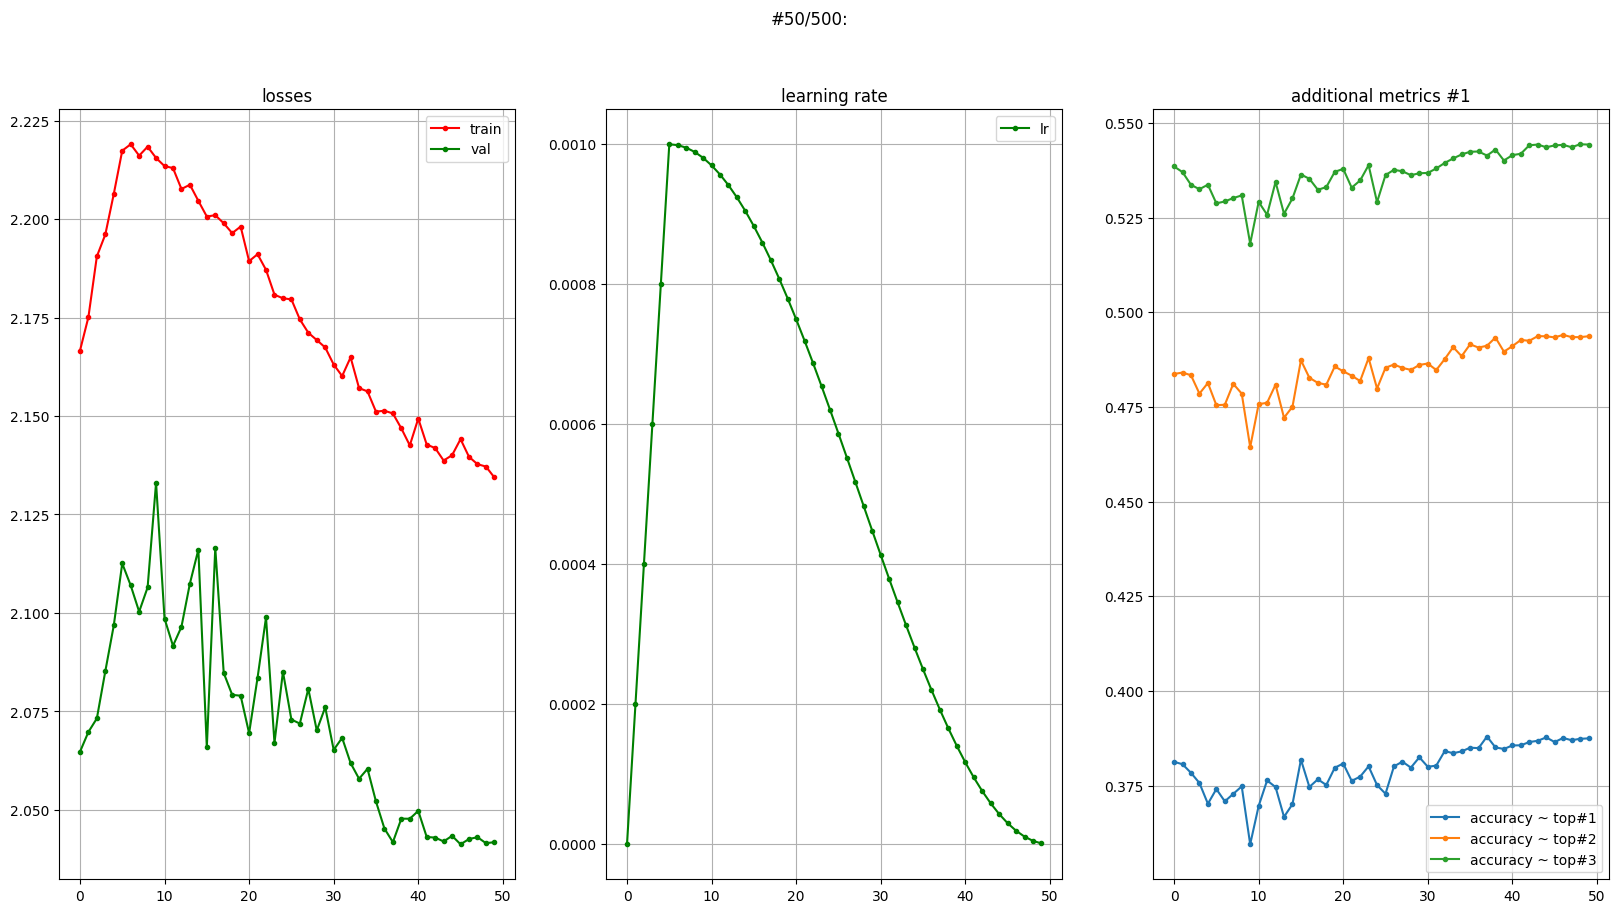

Learning process ended with early stop after epoch 50


In [20]:
scheduler = get_scheduler("cosine_with_restarts", optimizer, 5, 50)
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 500,
    min_lr = 1e-9,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 2, 3], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "gpt2smallWarmUpC22"
)

In [17]:
chkp_folder = "chkp"
model_name = "gpt2smallWarmUpC22"
epoch = 46
checkpoint = torch.load(os.path.join(chkp_folder, model_name, f'{model_name}#{epoch}.pt'))

model, optimizer = create_model_and_optimizer(
    model_class = gptKILLER,
    model_params = {
        "tokenizer": tokenizer, 
        "token_count": max_len,
        "labels": labels
    },
    lr = 1e-3,
    device = device,
)
model.load_state_dict(checkpoint['model_state_dict'])
# losses = checkpoint['losses']

<All keys matched successfully>

In [27]:
def get_title(index, d_test, device):
    title = d_test.title.to_numpy()[index]
    tokens = tokenizer(title, max_length=max_len, padding="max_length")
    return torch.Tensor([tokens["input_ids"]]).long().to(device), \
           torch.Tensor([tokens["attention_mask"]]).short().to(device)

In [50]:
answer_libs = []
for i in tqdm(range(len(d_test))):
    lib = d_train.lib.unique()[torch.argmax(model(*get_title(i, d_test, device)).cpu()).tolist()]
    answer_libs.append(lib)

  0%|          | 0/33506 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(answer_libs, columns=['lib'])

In [52]:
df["id"] = d_test["id"]

In [54]:
df.to_csv("submission.csv", sep='\t')